In [2]:
import requests, time
from bs4 import BeautifulSoup as bs
import re
import pandas as pd
import numpy as np
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
import functools
import operator
import string
from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB

from math import sqrt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

url = 'https://clientsfromhell.net/'

def pipe(obj, *fns):
    return functools.reduce(lambda x, y: y(x), [obj] + list(fns))

def get_categories(url):
    html = requests.get(url)
    response = bs(html.content, features="html.parser")
    get_items = [category for category in response.find_all('li', {'class':'flex items-center'})]
    categories = ['Dunces','Criminals','Deadbeats','Racists','Homophobes','Sexist','Frenemies','Cryptic','Ingrates','Chaotic Good']
    category_pair = []
    for item in get_items:
        href = item.find('a').get('href')
        item_name = re.sub('\\n','',item.text)
        pair = (item_name, href)
        if item_name in categories:
            category_pair.append(pair)
    return list(set(category_pair))

def url_categroy_creator(list_categories):

    list_url_patters = []

    for cat in list_categories:
        pattern = 'https://clientsfromhell.net'+cat[1]+'page/' # regex pattern for the urls to scrape
        list_url_patters.append((pattern,cat[0]))

    return list_url_patters
        
def page_num_creator(url_category_list : list):
    list_url_num =[]
    for url in url_category_list:
        html = requests.get(url[0]+'1')
        response = bs(html.content, "html.parser")
        list_items = response.find_all('a',{'class':'page-numbers'})

        len_=len(list_items)-2
        max_pag=list_items[len_].text
        list_url_num.append((url[0],max_pag,url[1]))
    return list_url_num

class IronhackSpider:
    
    def __init__(self, url_pattern, pages_to_scrape=1, sleep_interval=-1, content_parser=None):
        self.url_pattern = url_pattern
        self.pages_to_scrape = pages_to_scrape
        self.sleep_interval = sleep_interval
        self.content_parser = content_parser
  
    def scrape_url(self, url):
        response = requests.get(url)
        result = self.content_parser(response.content)
        return result
            
    def kickstart(self):
        list_pages = []
        for i in range(1, self.pages_to_scrape+1):
            list_pages.append(self.scrape_url(self.url_pattern % i))            
        return list_pages

def content_parser(content):
    return content

def case_parser(content):
    all_content = bs(content, "html.parser")
    pre_content = all_content.select('div [class="w-blog-post-content"] > p')
    
    case=[]
    
    for i, el in enumerate(pre_content):
        text = el.text
        case.append(text)

    return case

def initialize_scraping(url_pagenum_cat_list : list):
    
    html_cont_dict = {}

    for URL_PATTERN, PAGES_TO_SCRAPE, CAT in url_pagenum_cat_list:

        my_spider = IronhackSpider(URL_PATTERN+'%s/', int(PAGES_TO_SCRAPE), content_parser=case_parser)

        content = my_spider.kickstart()
        
        html_cont_dict.update({CAT: content})
        
    return html_cont_dict

def stem(sentence : string):
    p = PorterStemmer()
    sentence = [p.stem(word) for word in sentence]
    return sentence

def cleaning(df : pd.DataFrame):
    
    for col in df:

        for i,list_ in enumerate(df[col]):
            
            sub_list=[]

            for item in list_:
                if item.startswith('Client:'):
                    sub_list.append(item)

            df[col][i] = sub_list
    

    punc_list = [x for x in string.punctuation]

    for col in df:

        for i,list_ in enumerate(df[col]):

            sub_list = [x.replace('\xa0|\n|Client: ', ' ') for x in df[col][i]]
            
            for punc in punc_list:
                sub_list = [x.replace(punc, '') for x in sub_list]
                
            sub_list = [x.replace('—|   |  ', '').rstrip() for x in sub_list]

            df[col][i] = sub_list
            

    for col in df:

        for i,list_ in enumerate(df[col]):

            sub_list = [x.split(' ') for x in list_]

            df[col][i] = sub_list
            df[col][i] = [word.lower() for words in df[col][i] for word in words if len(word) != 1]
            df[col][i] = [re.sub(r'^(.)\1+', r'\1', word)  for word in df[col][i]]
            df[col][i] = [word.replace("’", "'") for word in df[col][i]]
            df[col][i] = [word.replace("client", "") for word in df[col][i]]
            df[col][i] = [word.rstrip("'") for word in df[col][i]]

            df[col][i] = [word for word in df[col][i] if word not in stopwords.words('english')]
            df[col][i] = [word for word in df[col][i] if word.isalpha() == True]
            df[col][i] = [word for word in df[col][i] if len(word) != 1]
            df[col][i] = stem(df[col][i])

    
    df_final = df.transpose()

    df_final.columns = [str(col) for col in df_final.columns]

    df_final.reset_index(inplace = True)
    df_final.rename(columns = {'index':'category'}, inplace = True)

    df_cases = pd.DataFrame(columns = ['category', 'case'])

    for col in df_final:
        if col != 'category':
            df_cases = df_cases.append(df_final[['category', col]].rename(columns = {col:'case'}))

    df_cases.reset_index(drop = True, inplace = True)

    for i, row in enumerate(df_cases['case']):
        if row == []:
            df_cases.drop(index = i, inplace = True)

    df_cases['case'] = df_cases['case'].apply(lambda x: ' '.join(x))
    df_cases.reset_index(drop = True, inplace = True) #ADDED

    return df_cases

# var = pipe(url, get_categories, url_categroy_creator, page_num_creator, initialize_scraping)
# df_clients_og = pd.DataFrame.from_dict(var, orient = 'index').fillna('').transpose()
# df_test = cleaning(df_clients_og)



In [13]:
def df_creator(dic_):
    df_ = pd.DataFrame.from_dict(dic_, orient = 'index').fillna('').transpose()
    return df_

def catetory_replacer(df, col = 'category'):
    dic_cat = {}
    
    for i, cat in enumerate(list(df[col].unique())):
        dic_cat[cat] = i
     
    df[col].replace(to_replace = dic_cat, inplace = True)
    
    return df, dic_cat

In [4]:
def t_t_split(df, target_col = 'category'):
    
    features = df[[col for col in df.columns if col != target_col]]
    target = df[[target_col]]

    
    X_train, X_test, y_train, y_test = train_test_split(
        features, # Features (X)
        target, # Target (y)
        test_size = .2,
        random_state = 42
    )
    return X_train, X_test, y_train, y_test

In [5]:
def list_split(string_):
    list_ = string_.split()
    return list_

def convert_to_word_col(df, case_col = 'case', target_col = 'category'):
    
    series_ = df[case_col].apply(lambda x: list_split(x))
    series_ = series_.apply(lambda x: dict(Counter(x)))
    
    df_series = pd.DataFrame(series_)
    df_count = pd.DataFrame()
    
    for i in range(df_series.shape[0]):
        df_count = df_count.append(pd.DataFrame(df_series[case_col][i], index=[0]))
        
    df_count.reset_index(drop = True, inplace = True)
        
    df_ = df[[target_col]]
    df_ = df_.merge(df_count, left_index=True, right_index= True)
    df_.fillna(0, inplace = True)
    
    return df_


In [6]:
def all_num_models_fitting(X_train, y_train):

    log_regr = LogisticRegression(solver = 'lbfgs')
    log_regr.fit(X_train, y_train.values.ravel())

    knn = KNeighborsClassifier(n_neighbors = 3) # k = 5 by default
    knn.fit(X_train, y_train.values.ravel())

    multi = MultinomialNB()
    multi.fit(X_train, y_train.values.ravel())

    rfc = RandomForestClassifier(max_depth=10, random_state=42)
    rfc.fit(X_train, y_train.values.ravel())
    
    return log_regr, knn, multi, rfc
    
    
    

In [19]:
def all_bool_models_fitting(X_train, y_train):

    bernoulli = BernoulliNB().fit(X_train, y_train.values.ravel())

    guassian = GaussianNB().fit(X_train, y_train.values.ravel())
    
    return bernoulli, guassian

In [8]:
def model_score(model, X_test, y_test):
    
    score = model.score(X_test, y_test)*100
    
    if score >= 50.0:
        
        print('Score: ',score,'%')
        print("DON'T GET COCKY NOW!!! KEEP MAKING IT BETTER!")
        print('')
    elif score < 50.0:
        
        print('Score: ',score,'%')
        print("Your algorithm stinks so much, I could toss a coin and make better predictions =P...")
        print('')
    
    return score

In [9]:
def predict(model, X_test):
    prediction = model.predict(X_test)
    return prediction
    

In [10]:
def model_metrics(y_test, prediction):

    r2 = r2_score(y_test, prediction)

    mse = mean_squared_error(y_test, prediction)

    rmse = sqrt(mean_squared_error(y_test, prediction))

    mae = mean_absolute_error(y_test, prediction)

    acc = accuracy_score(y_test, prediction)
    
    bacc = balanced_accuracy_score(y_test, prediction)

    prec = precision_score(
        y_test,
        prediction,
        pos_label = 2,
        average = 'weighted'
    )
    
    rec = recall_score(
    y_test,
    prediction,
    pos_label = 2,
    average = 'weighted'
    )

    f1 = f1_score(
        y_test,
        prediction,
        pos_label = 2,
        average = 'weighted'
    )
    
    return r2, mse, rmse, mae, acc, bacc, prec, rec, f1

In [123]:
def run_all_models_and_score(df):

    X_train, X_test, y_train, y_test = t_t_split(df)
    
    X_train_bool = X_train.astype(bool)
    
    X_test_bool = X_test.astype(bool)

    models = all_num_models_fitting(X_train, y_train) #log_regr, knn, multi, rfc
    
    models = models + all_bool_models_fitting(X_train_bool, y_train) #adding ber, gau
    
    metrics_names = ['R2: ', 'MSE: ', 'RMSE: ', 'MAE: ',
                     'Accuracy: ', 'Balanced Acc: ', 'Precision: ',
                     'Recall: ', 'F1 Score: ']
    
    model_names = ['Log Regression', 'KNN', 'Multinomial', 'Random Forest', 'Bernoulli', 'Gaussian']
    
    for i, model in enumerate(models):
        if i < 4:
            
            print(model_names[i])
            print('')
            model_score(model, X_test, y_test) #returns score and prints it
            for j, name in enumerate(metrics_names):
                  print(name, model_metrics(y_test, predict(model, X_test))[j]) #r2, mse, rmse, mae, acc, bacc, prec, rec, f1
            print('')
        else:
            
            print(model_names[i])
            print('')
            model_score(model, X_test_bool, y_test) #returns score and prints it
            for j, name in enumerate(metrics_names):
                  print(name, model_metrics(y_test, predict(model, X_test_bool))[j]) #r2, mse, rmse, mae, acc, bacc, prec, rec, f1
            print('')

In [21]:
pipe( #Overall Pipe
    pipe( # This Pipe does all the scraping and cleaning
        url, #Website URL
        get_categories, url_categroy_creator, page_num_creator, #Scrapper
        initialize_scraping,
        df_creator, cleaning, catetory_replacer #Building Raw Data Frame
        )[0], #Data Frame: 0, Dictionary of Categories: 1
    convert_to_word_col, # Converting sentences to word columns
    run_all_models_and_score #Running and Scoring all models
)

Log Regression

Score:  63.793103448275865 %
DON'T GET COCKY NOW!!! KEEP MAKING IT BETTER!

R2:  -0.0754418113488835
MSE:  10.293103448275861
RMSE:  3.2082866842406497
MAE:  1.6379310344827587
Accuracy:  0.6379310344827587
Balanced Acc:  0.38213507625272336
Precision:  0.5686371100164204
Recall:  0.6379310344827587
F1 Score:  0.586863711001642

KNN

Score:  36.206896551724135 %
Your algorithm stinks so much, I could toss a coin and make better predictions =P...

R2:  -0.7888001987762838
MSE:  17.120689655172413
RMSE:  4.137715511628659
MAE:  2.9482758620689653
Accuracy:  0.3620689655172414
Balanced Acc:  0.1707390648567119
Precision:  0.33979128856624324
Recall:  0.3620689655172414
F1 Score:  0.3001209895246585

Multinomial

Score:  58.620689655172406 %
DON'T GET COCKY NOW!!! KEEP MAKING IT BETTER!

R2:  -0.2501785880672114
MSE:  11.96551724137931
RMSE:  3.459120876954043
MAE:  2.0344827586206895
Accuracy:  0.5862068965517241
Balanced Acc:  0.2712418300653595
Precision:  0.417310097750

In [114]:
df_test = pipe( # This Pipe does all the scraping and cleaning
    url, #Website URL
    get_categories, url_categroy_creator, page_num_creator, #Scrapper
    initialize_scraping,
    df_creator, cleaning, catetory_replacer #Building Raw Data Frame
        )

In [115]:
df_test[0]

,category,case
0,0,hey place ep file word document respons imag c...
1,1,offic door littl girl work offens thing call c...
2,2,divers enough mayb divers enough divers divers...
3,3,hire logo us fix logo want show ribbon bubbl a...
4,4,got bill say owe send bill septemb yall check ...
...,...,...
283,0,name sort stupid introduc getgo move need nda ...
284,0,finish product seem exactli concept mani idea ...
285,0,decid want call new websit ah yeah like net mu...
286,0,outrag last crew could five minut six twelv ti...


In [53]:
def convert_to_tfidf(df, case_col = 'case', target_col = 'category'):
    
    tfidf = TfidfVectorizer()
    word_count_vectors = tfidf.fit_transform(df[case_col].values).todense().tolist()
    
    features = pd.DataFrame(
    data = word_count_vectors,
    columns = tfidf.get_feature_names()
    )

    df_ = features.merge(df[target_col], left_index=True, right_index= True)
    
    return df_

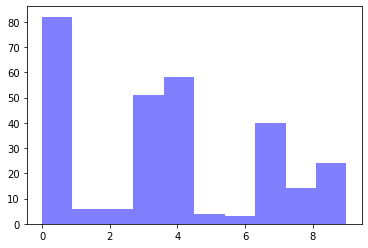

In [154]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

num_bins = 10
n, bins, patches = plt.hist(df_test[0]['category'], num_bins, facecolor='blue', alpha=0.5)
plt.show()

# df_test_real = df_test[0]

# df_test_real['category'] = df_test_real['category'].apply(lambda x: x.replace(2) if x > 4)

# df_test_real[df_test_real['category'] == 0].shape[0]

# n, bins, patches = plt.hist(df_test_real['category'], num_bins, facecolor='blue', alpha=0.5)
# plt.show()

In [153]:
df_test_real = df_test[0].copy()

In [117]:
def under_sampling_3_val_by_index(df_, high = 0, mid = 2, low = 1, col_name = 'category'):
    
    def convert_3(int_):
        if int_ > 4:
            return 2
        elif int_ == 4:
            return 1
        elif int_ == 0:
            return 0
        elif int_ == 1: 
            return 2
        elif int_ == 2: 
            return 2
        elif int_ == 3: 
            return 0
    
    df = df_[[col for col in df_.columns if col != col_name]]
    
    df[col_name] = df_[col_name].apply(lambda x: convert_3(x))
    
    low_size = len(df[df[col_name] == low])
    
    high_indices = df[df[col_name] == high].index
    
    mid_indices = df[df[col_name] == mid].index
    
    low_indices = df[df[col_name] == low].index
    
    random_high_indices = np.random.choice(high_indices, low_size, replace=False)
    
    random_mid_indices = np.random.choice(mid_indices, low_size, replace=False)
    
    under_sample_indices = np.concatenate([random_high_indices,random_mid_indices,low_indices])
    
    under_sample = df.loc[under_sample_indices]
    
    under_sample = under_sample.reset_index(drop = True)
    
    return under_sample
    

In [125]:
pipe( #Overall Pipe
    df_test_real, #Data Frame: 0, Dictionary of Categories: 1
    under_sampling_3_val_by_index, #Undersampling
    convert_to_word_col, # Converting sentences to word columns
    run_all_models_and_score #Running and Scoring all models
)

Log Regression

Score:  71.42857142857143 %
DON'T GET COCKY NOW!!! KEEP MAKING IT BETTER!

R2:  -0.2628865979381445
MSE:  0.8
RMSE:  0.8944271909999159
MAE:  0.45714285714285713
Accuracy:  0.7142857142857143
Balanced Acc:  0.6988636363636364
Precision:  0.7522344322344322
Recall:  0.7142857142857143
F1 Score:  0.7226757369614513

KNN

Score:  28.57142857142857 %
Your algorithm stinks so much, I could toss a coin and make better predictions =P...

R2:  -2.292525773195877
MSE:  2.085714285714286
RMSE:  1.4442002235542986
MAE:  1.1714285714285715
Accuracy:  0.2857142857142857
Balanced Acc:  0.32954545454545453
Precision:  0.4304761904761905
Recall:  0.2857142857142857
F1 Score:  0.2921168467386955

Multinomial

Score:  68.57142857142857 %
DON'T GET COCKY NOW!!! KEEP MAKING IT BETTER!

R2:  -0.44329896907216515
MSE:  0.9142857142857143
RMSE:  0.9561828874675149
MAE:  0.5142857142857142
Accuracy:  0.6857142857142857
Balanced Acc:  0.7083333333333334
Precision:  0.7828571428571428
Recall:  0

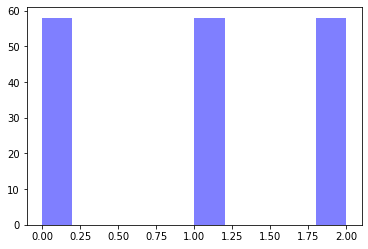

Log Regression

Score:  71.42857142857143 %
DON'T GET COCKY NOW!!! KEEP MAKING IT BETTER!

R2:  -0.668814432989691
MSE:  1.0571428571428572
RMSE:  1.0281745265969475
MAE:  0.5428571428571428
Accuracy:  0.7142857142857143
Balanced Acc:  0.7821969696969697
Precision:  0.873015873015873
Recall:  0.7142857142857143
F1 Score:  0.7182399381157145

KNN

Score:  57.14285714285714 %
DON'T GET COCKY NOW!!! KEEP MAKING IT BETTER!

R2:  -1.0296391752577323
MSE:  1.2857142857142858
RMSE:  1.1338934190276817
MAE:  0.7142857142857143
Accuracy:  0.5714285714285714
Balanced Acc:  0.6268939393939394
Precision:  0.6479591836734695
Recall:  0.5714285714285714
F1 Score:  0.5590062111801242

Multinomial

Score:  51.42857142857142 %
DON'T GET COCKY NOW!!! KEEP MAKING IT BETTER!

R2:  -1.6610824742268044
MSE:  1.6857142857142857
RMSE:  1.2983506020002016
MAE:  0.8857142857142857
Accuracy:  0.5142857142857142
Balanced Acc:  0.6041666666666666
Precision:  0.7726530612244897
Recall:  0.5142857142857142
F1 Score:

In [126]:
pipe( #Overall Pipe
    df_test_real, #Data Frame: 0, Dictionary of Categories: 1
    under_sampling_3_val_by_index, #Undersampling
    convert_to_tfidf, # Converting sentences to word columns with tfidf method
    run_all_models_and_score #Running and Scoring all models
)

In [ ]:
def evaluate_model(model, train_X, test_X, train_y, test_y):
    
    model = algorithm().fit(train_X, train_y)
    score = model.score(test_X, test_y)
#     print(f"Accuracy: {round(score, 2)}")
    return model, score

In [144]:
def k_fold_score(df, model_name, target = 'category'):
    scores = []
    features = df[[col for col in df if col != target]]
    target = df[target]
    kf = KFold(n_splits = 5, random_state = 42)
    for train_i, test_i in kf.split(df):
        
        X_train = features.iloc[train_i]
        X_test = features.iloc[test_i]
        y_train = target.iloc[train_i]
        y_test = target.iloc[test_i]
        
        X_train_bool = X_train.astype('bool')
        X_test_bool = X_test.astype('bool')
        
        models = all_num_models_fitting(X_train, y_train) #log_regr, knn, multi, rfc
        models = models + all_bool_models_fitting(X_train_bool, y_train) #adding ber, gau
        
        model_names = {'Log Regression': 0, 'KNN': 1, 'Multinomial': 2, 'Random Forest': 3, 'Bernoulli': 4, 'Gaussian': 5}

        model_names.get(model_name)
        
        if model_names.get(model_name) < 4:
            score = models[model_names.get(model_name)].score(X_test, y_test) #returns score 
            scores.append(score)
        else:
            score = models[model_names.get(model_name)].score(X_test_bool, y_test) #returns score 
            scores.append(score)
        
    return sum(scores) / len(scores)

In [151]:
def run_all_models_and_score_k_fold(df):

    X_train, X_test, y_train, y_test = t_t_split(df)
    
    X_train_bool = X_train.astype(bool)
    
    X_test_bool = X_test.astype(bool)

    models = all_num_models_fitting(X_train, y_train) #log_regr, knn, multi, rfc
    
    models = models + all_bool_models_fitting(X_train_bool, y_train) #adding ber, gau
    
    metrics_names = ['R2: ', 'MSE: ', 'RMSE: ', 'MAE: ',
                     'Accuracy: ', 'Balanced Acc: ', 'Precision: ',
                     'Recall: ', 'F1 Score: ']
    
    model_names = ['Log Regression', 'KNN', 'Multinomial', 'Random Forest', 'Bernoulli', 'Gaussian']
    
    for i, model in enumerate(models):
        if i < 4:
            
            print(model_names[i])
            print('')
            print('kfold score: ',k_fold_score(df, model_names[i])*100,'%') #prints score kfold
            print('')
            model_score(model, X_test, y_test)
            for j, name in enumerate(metrics_names):
                  print(name, model_metrics(y_test, predict(model, X_test))[j]) #r2, mse, rmse, mae, acc, bacc, prec, rec, f1
            print('')
        else:
            
            print(model_names[i])
            print('')
            print('kfold score: ',k_fold_score(df, model_names[i])*100,'%') #prints score kfold
            print('')
            model_score(model, X_test, y_test)
            for j, name in enumerate(metrics_names):
                  print(name, model_metrics(y_test, predict(model, X_test_bool))[j]) #r2, mse, rmse, mae, acc, bacc, prec, rec, f1
            print('')

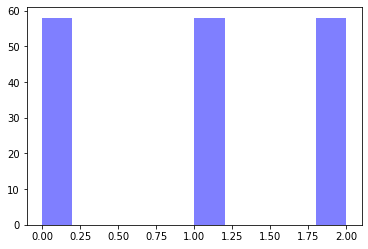

Log Regression

kfold score:  13.142857142857142 %

Score:  65.71428571428571 %
DON'T GET COCKY NOW!!! KEEP MAKING IT BETTER!

R2:  -0.7590206185567014
MSE:  1.1142857142857143
RMSE:  1.0555973258234952
MAE:  0.6
Accuracy:  0.6571428571428571
Balanced Acc:  0.6875
Precision:  0.734850863422292
Recall:  0.6571428571428571
F1 Score:  0.6520816326530613

KNN

kfold score:  40.38655462184874 %

Score:  48.57142857142857 %
Your algorithm stinks so much, I could toss a coin and make better predictions =P...

R2:  -0.48840206185567037
MSE:  0.9428571428571428
RMSE:  0.9710083124552245
MAE:  0.6571428571428571
Accuracy:  0.4857142857142857
Balanced Acc:  0.4696969696969697
Precision:  0.5314285714285715
Recall:  0.4857142857142857
F1 Score:  0.4542124542124542

Multinomial

kfold score:  4.571428571428571 %

Score:  54.285714285714285 %
DON'T GET COCKY NOW!!! KEEP MAKING IT BETTER!

R2:  -0.8041237113402064
MSE:  1.1428571428571428
RMSE:  1.0690449676496976
MAE:  0.6857142857142857
Accuracy:  

In [155]:
pipe( #Overall Pipe
    df_test_real, #Data Frame: 0, Dictionary of Categories: 1
    under_sampling_3_val_by_index, #Undersampling
    convert_to_tfidf, # Converting sentences to word columns with tfidf method
    run_all_models_and_score_k_fold #Running and Scoring all models
)